In [24]:
# install dlib using the below command 
# conda install -c conda-forge dlib
# and download the shape_predictor_68_face_landmarks.dat file from http://dlib.net/files/

In [25]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import dlib


In [26]:
donald = cv.imread('images/donald_trump.jpg')
donald = cv.cvtColor(donald, cv.COLOR_BGR2RGB)

hillary = cv.imread('images/hillary_clinton.jpg')
hillary = cv.cvtColor(hillary, cv.COLOR_BGR2RGB)

In [2]:
points1 = []
points2 = []

def GenerateTiePoints():
    # detect face points
    # make a face detector
    points1 = []
    points2 = []
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    faces = detector(donald)

    landmarks_arr1= [(0,0), 
                    (0,donald.shape[0]-1), 
                    (donald.shape[1]-1, 0),
                    (donald.shape[1]-1, donald.shape[0]-1),
                    ((donald.shape[1]-1)/2, 0),
                    ((donald.shape[1]-1)/2, (donald.shape[0]-1)/2),
                    (0,(donald.shape[0]-1)/2)
                    ]

    # traverse through each possible face in faces we got from detector
    for face in faces:
        # landmarks are nothing but the points which is a possible tie points in the image
        landmarks = predictor(donald, face)
        
        # since the shape_predictor uses a dat file of 68 points, we traverse through all those 68 points and add them to an array for delaunay triangulation
        for i in range(68):
            x =  landmarks.part(i).x
            y =  landmarks.part(i).y
            landmarks_arr1.append((x,y ))
        points1 = np.array(landmarks_arr1, dtype='uint32')

    faces = detector(hillary)
    landmarks_arr2 = [(0,0), 
                    (0,hillary.shape[0]-1), 
                    (hillary.shape[1]-1, 0),
                    (hillary.shape[1]-1, hillary.shape[0]-1),
                    ((hillary.shape[1]-1)/2, 0),
                    ((hillary.shape[1]-1)/2, (hillary.shape[0]-1)/2),
                    (0,(hillary.shape[0]-1)/2)
                    ]

    # traverse through each possible face in faces we got from detector
    for face in faces:
        # landmarks are nothing but the points which is a possible tie points in the image
        landmarks = predictor(donald, face)
        
        # since the shape_predictor uses a dat file of 68 points, we traverse through all those 68 points and add them to an array for delaunay triangulation
        for i in range(68):
            x =  landmarks.part(i).x
            y =  landmarks.part(i).y
            landmarks_arr1.append((x,y ))
        points2 = np.array(landmarks_arr2, dtype='uint32')

    return points1, points2

# this is for generating tie points using dlib model 
points1, points2 = GenerateTiePoints()

NameError: name 'dlib' is not defined

In [28]:
def AffineTransform(img,triPoints1, triPoints2,w,h):
    matrix = cv.getAffineTransform(np.float32(triPoints1), np.float32(triPoints2))
    
    result = cv.warpAffine(img, matrix, (w,h))
    
    return result


In [3]:

def takePointsFromTextFile():
    points1 = []
    points2 = []
    with open("images/tiepoints.txt") as file:
        range = int(file.readline())

        for line in file:
            x1, y1, x2, y2 = line.split()
            points1.append((int(x1),int(y1)))
            points2.append((int(x2),int(y2)))
            

    return points1, points2

# this is for taking tie points from the textfile
points1, points2 = takePointsFromTextFile()
point1 = Delaunay(points1)    
point2 = Delaunay(points2)

NameError: name 'Delaunay' is not defined

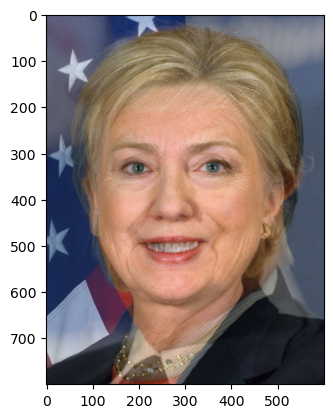

In [31]:
def MorphMyImage(alpha):

        # find all the points that will be there in the morphed image
    intermediate_points = []

    for i in range(len(points2)):
        # print()
        x = (1.0-alpha)*points1[i][0] + alpha*points2[i][0]
        y = (1.0-alpha)*points1[i][1] + alpha*points2[i][1]
        intermediate_points.append((x,y))

    # convert to np array
    intermediate_points = np.int32(intermediate_points)

    # this is the new morphed image
    morphed_image = np.zeros(hillary.shape, dtype=hillary.dtype)


    for i in range(len(point1.simplices)):

        # IMP -  for each triangle we make a bounding box(rectangle) and then fill the extra portion which is not in triangle with a mask, this is done because we can't directly access a triangle, so we first take the rectangle then fill the unwanted portions.
        a = point1.simplices[i][0] 
        b = point1.simplices[i][1] 
        c = point1.simplices[i][2]
        
        tri1 = np.float32([points1[a], points1[b], points1[c]])
        tri2 = np.float32([points2[a], points2[b], points2[c]])
        tri_intermediate = np.float32([intermediate_points[a],intermediate_points[b], intermediate_points[c]])

        # bounding box for image triangles
        rect1 = cv.boundingRect(tri1)
        rect2 = cv.boundingRect(tri2)
        rect_inter = cv.boundingRect(tri_intermediate)

        # get all informations

        # get information from bounding box1
        (x1,y1,w1,h1) = rect1
        Tri_rect1 = []
        # find coordinates of the 3 points of triangle in the boundingRectangle
        for i in range(3):
            Tri_rect1.append((
                (tri1[i][0]-x1), 
                (tri1[i][1]-y1)
                ))

        # # get information from bounding box2
        (x2,y2,w2,h2) = rect2

        Tri_rect2 = []
        # find coordinates of the 3 points of triangle in the boundingRectangle
        for i in range(3):
            Tri_rect2.append((
                (tri2[i][0]-x2), 
                (tri2[i][1]-y2)
                ))
            
        # get information for bounding box intermediate
        (x_i, y_i, w_i, h_i) = rect_inter
        Tri_rect_inter = []
        # find coordinates of the 3 points of triangle in the boundingRectangle
        for i in range(3):
            Tri_rect_inter.append((
                (tri_intermediate[i][0] - x_i), 
                (tri_intermediate[i][1] - y_i)
                ))
            
        # create a mask of size of intermediate bounding rectangle
        mask = np.zeros((h_i, w_i, 3), dtype=np.float32)

        cv.fillConvexPoly(mask,np.int32(Tri_rect_inter), (1.0,1.0,1.0), 16, 0)

        # warping bounding rectangles by first extracting a section of the original image
        img1 = donald[y1:y1+h1,x1:x1+w1]
        img2 = hillary[y2:y2+h2,x2:x2+w2]

        # now warping img1 and img2
        warp1 = AffineTransform(img1, Tri_rect1, Tri_rect_inter, w_i, h_i)
        warp2 = AffineTransform(img2, Tri_rect2, Tri_rect_inter, w_i, h_i)

        # using the (1-alpha)*A + alpha*B algo to morph these warped patches
        img = (1-alpha) * warp1 + alpha * warp2

        # the triangular region we had in rectangular patches, we have to put them on our morphed image
        morphed_image[y_i:y_i+h_i, x_i:x_i+w_i] = morphed_image[y_i:y_i+h_i, x_i:x_i+w_i] * ( 1 - mask ) + img * mask

    return morphed_image
morphed_image = MorphMyImage(0.6)
plt.imshow(morphed_image)

In [32]:
for i in range(100):
    alpha = i/100
    morphed_image = MorphMyImage(alpha)
    fname = f'morph/img{i}.png'
    plt.imsave(fname, morphed_image)